# Chroma from Luma (CfL)

Outline
* Intro
  * ~~Overall description~~
  * ~~Other CfL Implementation~~
  * ~~How this is different~~
* Fundamentals
  * ~~Model fitting~~
  * ~~Simplifications~~
* Quantization
  * Alphabet size
  * Alphabet values
* Signaling
* Integration with AV1
* Results

In [2]:
%matplotlib inline

import numpy as np
from scipy.ndimage  import imread
import matplotlib.pyplot as plt

from numpy import genfromtxt
import os

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [136]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('#toggle').attr('value', 'Show code')  
 } else {
 $('div.input').show();
 $('#toggle').attr('value', 'Hide code') 
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggle" value="Show code"></form>''')

## Introduction

Chroma from Luma (CfL) is a coding tool that predicts information in the chromatic planes based on previously encoded information in the Luma plane. The underlining assumption is that a correlation exists between the Luma plane and its chromatic counterparts. This correlation can be seen in the following image, notice the ressemblance between the chromatic planes (Cr and Cr) and the Luma plane.

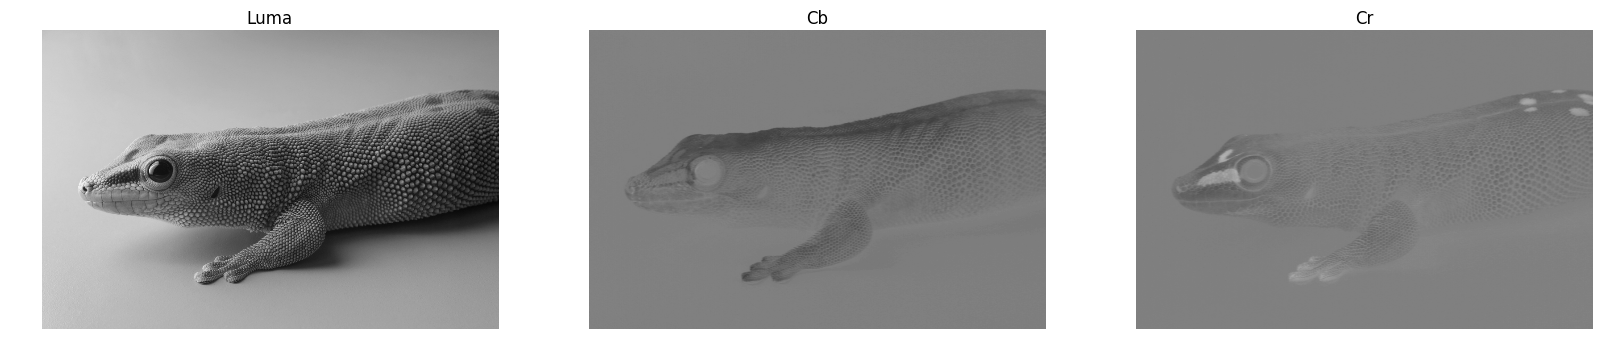

In [138]:
def showPlanes(im):
    plt.figure(figsize=(20,15))
    plt.subplot(1,3,1)
    showImage(im[:,:,0], "Luma")
    plt.subplot(1,3,2)
    showImage(im[:,:,1], "Cb")
    plt.subplot(1,3,3)
    showImage(im[:,:,2], "Cr")


def showImage(im, title):
    plt.imshow(im, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
    plt.axis('off')
    plt.title(title)
    

im = imread("../../videos/lizard.jpg", mode="YCbCr")
showPlanes(im);

In this document, we present the proposed CfL approach for the AV1 Codec. This new version of CfL draws from the strengths of the Cfl implementation of the Thor codec and the Cfl implementation of the Daala codec. 

In [[1]](https://tools.ietf.org/html/draft-midtskogen-netvc-chromapred-02), Midtskogen proposes to compute $\alpha$ and $\beta$ using the predicted values of Luma and Chroma. These values are available in both the encoder and decoder. As such, they are not signaled in the bitstream. Additionally, Midtskogen uses a threshold of 64 on the mean squared error between the reconstructed Luma pixel and the predicted Luma pixel to decide whether or not CfL should be used. An important note about the work of Midtskogen is that it applies to intra frame coding and inter frame coding.

In [[2]](https://people.xiph.org/~unlord/spie_cfl.pdf), Egge and Valin propose a frequency domain version of CfL. the authors exploit the gain-shape coding nature of perceptual vector quantization (PVQ) to avoid having to perform model fitting to find $\alpha$ and $\beta$. As such, only a sign bit needs to be signaled. It is important to note that this version of CfL only predicts ACs coefficients.

The proposed solution is similar to [1] in the it is performed in the spatial domain and least squares is used. However, it differs from [1] in that $\alpha$ is signaled in the bitstream. As for $\beta$, Midtskogen computes it using the least squares equation, we propose to use DC_PRED as the value of $\beta$. This aligns with [2], in that CfL does not predict the DC.

The characteristics of the different CfL implementations are described in the following table.

|                                | Thor[1]    | Daala[1]  | Proposed |
|--------------------------------|------------|-----------|----------|
| Prediction Domain              | Spatial    | Frequency | Spatial  |
| Bitstream Signaling            | None       | Sign bit  | Alpha    |
| Encoder model fitting          | Yes        | Via PVQ   | Yes      |
| Decoder model fitting          | Yes        | No        | No       |
| Luma values used for fit       | Predicted  | Luma      | Luma     |
| Chroma values used for fit     | Predicted  | Chroma    | Chroma   |


## CfL Fundamentals

Although it does not always hold, the assumption of a linear relationship between the luma plane and its chromatic counterparts is not farfetched. For example, the following image shows the relationship between the Luma and Chroma for an $8 \times 8$ block in the previous lizard image.


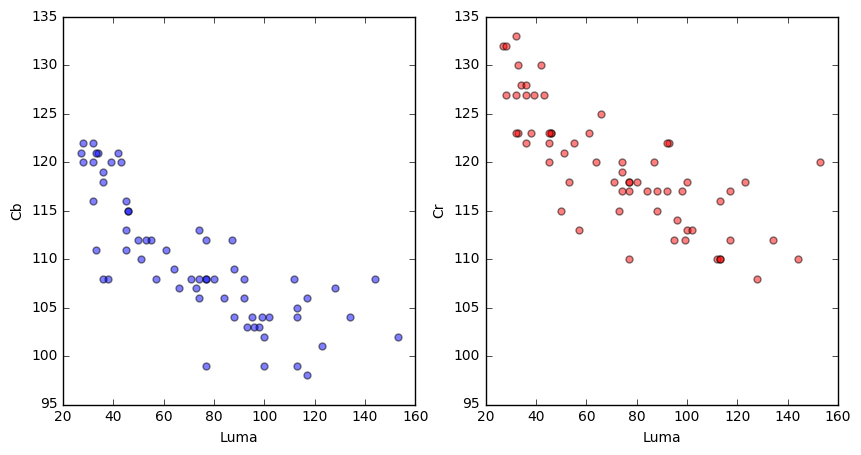

In [152]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(im[300:308,500:508,0].ravel(), im[300:308,500:508,1].ravel(), c="blue", alpha=0.5, s=25)
plt.xlabel("Luma")
plt.ylabel("Cb")
plt.gca().set_ylim([95, 135])
plt.subplot(1,2,2)
plt.scatter(im[300:308,500:508,0].ravel(), im[300:308,500:508,2].ravel(), c="red", alpha=0.5, s=25)
plt.xlabel("Luma")
plt.ylabel("Cr")
plt.gca().set_ylim([95, 135]);

Assuming that this relationship also exists between the $i$th reconstructed Luma pixel $\hat{L}_i$ and $i$th Chroma pixel $C_i$, 
a chromatic prediction of $C_i$ can be computed using the following equation

$$C'_i = \alpha \times \hat{L}_i + \beta,$$

where $\alpha$ is the slope and $\beta$ is y intercept. For a block of $N$ pixels, $\alpha$ and $\beta$ are computed with the least squares equations as follows

$$\alpha = \frac{N \sum_i \hat{L}_i C_i - \sum_i \hat{L}_i \sum_i C_i}{N \sum_i L_i^2 - (\sum \hat{L}_i)^2},$$

$$\beta = \frac{\sum_i C_i - \alpha \sum_i \hat{L}_i}{N}.$$

As explained in [1], signaling $\alpha$ and $\beta$ on a per block basis is too expensive. To avoid signaling these parameters, Midtskogen proposes instead to compute $\alpha'$ and $\beta'$ by replacing the actual values $\hat{L}$ and $C$ by their predicted counterparts $L'$ and $C'$. 

CfL_Cb PSNR: 41.55 dB
CfL_Cr PSNR: 42.91 dB


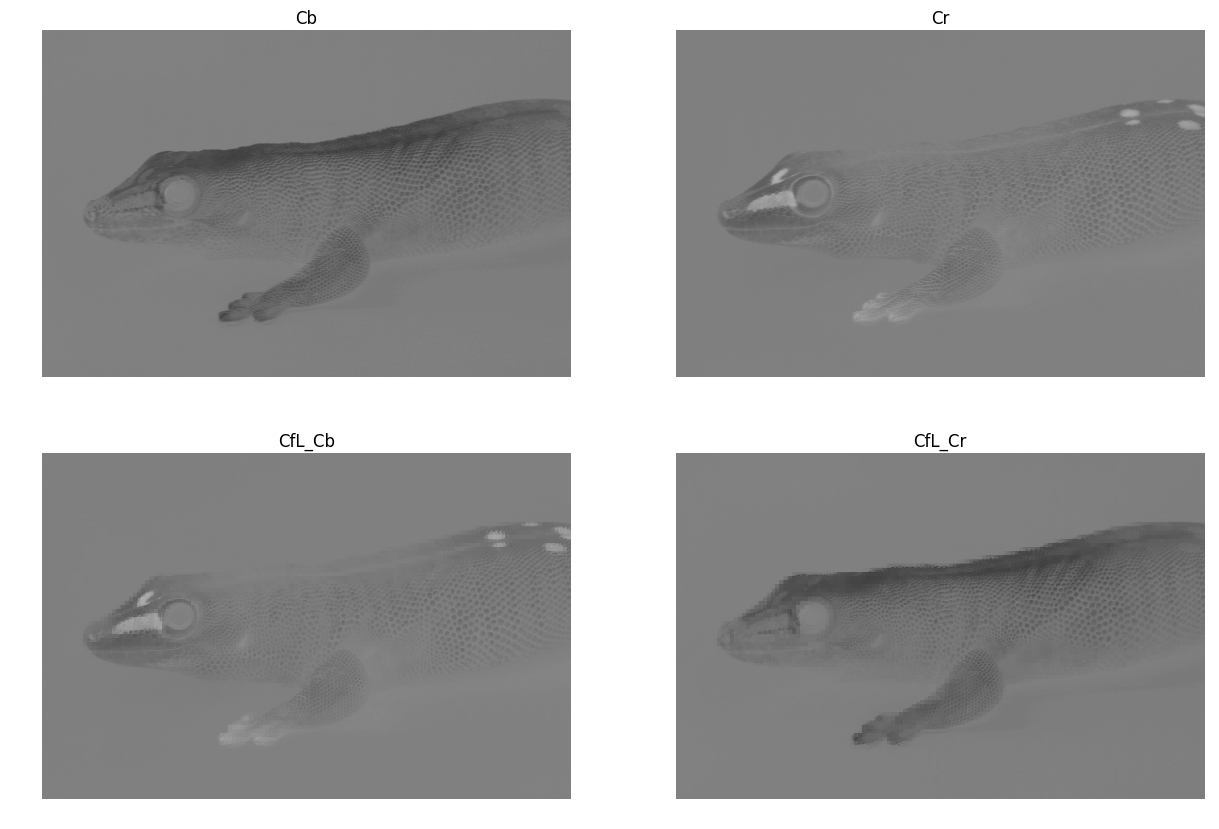

In [151]:
block_size = 8

def psnr(im1, im2):
    h, w = im1.shape
    sse = np.sum((im1 - im2)**2)
    return 20 * np.log10(255) - 10 * np.log10(sse/(h*w))

def cfl(im, block_size, plane):
    height, width, z = im.shape
    cfl = np.array(np.zeros((height, width)), dtype='uint8')
    
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            bY = im[y:y+block_size, x:x+block_size, 0]
            bC = im[y:y+block_size, x:x+block_size, plane]
            
            L = bY - np.mean(bY)
            C = bC - np.mean(bC)
            
            sLL = np.sum(L*L)
            sLC = np.sum(L*C)
            
            if sLL != 0:
                a = sLC / sLL
            else:
                a = 0
            cfl[y:y+block_size, x:x+block_size] = np.round(a * L + np.mean(bC))
    return cfl

cfl_cb = cfl(im, 8, 1)
cfl_cr = cfl(im, 8, 2)
    
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
showImage(im[:,:,1], "Cb")
plt.subplot(2,2,3)
showImage(cfl_cr, "CfL_Cb")
plt.subplot(2,2,2)
showImage(im[:,:,2], "Cr")
plt.subplot(2,2,4)
showImage(cfl_cb, "CfL_Cr")

print("CfL_Cb PSNR: %0.2f dB" % psnr(im[:,:,1], cfl_cb))
print("CfL_Cr PSNR: %0.2f dB" % psnr(im[:,:,2], cfl_cr))

The advantage of such and approach is that $L'$ and $C'$ are available to both the encoder and decoder, the model fitting is performed during encoding and during decoding, thus signaling alpha and beta is avoided. The disadvantage of this approach is that the model will fit the prediction but not the actual data. In the context of intra coding, the prediction might significantly differ from the actual values. This loss of precision will increase distortion and rate.

Fitting the model on the real values of $\hat{L}$ and $C$ generates a more precise model. However, this information is not available to the decoder and must be signaled in the bitstream. In this proposal, we will present different techniques to reduce the rate required to signal the model fitting parameters.

Let $\bar{L}$ be the subtraction of $\hat{L}$ by its average for a given block. Notice that $\bar{L}$ is zero mean, it follows that

$$\sum_i \bar{L_i} = 0.$$

Notice that when we replace $\hat{L}$ with $\bar{L}$ in the equation of $\beta$, we get the average chromatic pixel value. It just so happens that the intra prediction mode DC_PRED is designed to predict the average pixel value.

Next, let $\bar{C'}$ be the subtraction of $C$ by the predicted average using DC_PRED.

Replacing $\hat{L}$ by $\bar{L}$ and $C$ with $\bar{C'}$ in the equations of $\alpha$ and $\beta$ yields

$$\bar{\alpha} = \frac{\sum_i \bar{L}_i \bar{C'}_i}{\sum_i \bar{L}_i^2},$$

$$\bar{\beta} = \frac{\sum_i \bar{C'}_i}{N}.$$

Notice that $\bar{\beta}$ is the average of the residual of the chromatic block.

Based on the assumption that $\bar{\beta} \approx 0$, we predict chroma as follows

$$ C''_i = \bar{\alpha} \times \bar{L_i} + DC\_PRED $$

_Note that it could also be possible to signal $\sum_i \bar{L_i} \bar{C'_i}$ instead of $\alpha$. However, signaling $\alpha$ give better results._

The following images show the proposed CfL predictions for the Cb and Cr planes.

CfL_Cb PSNR: 39.01 dB
CfL_Cr PSNR: 40.34 dB


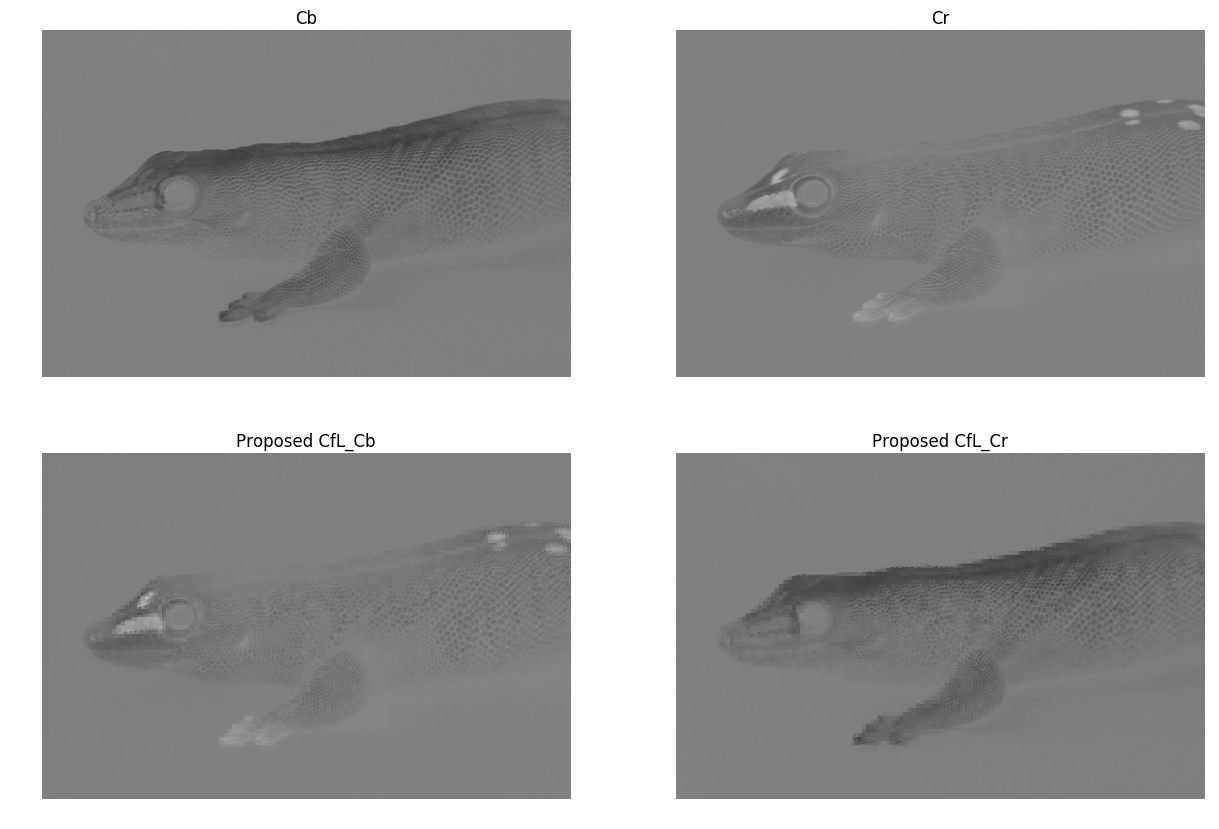

In [103]:
def cfl_prop(im, block_size, plane):
    height, width, z = im.shape
    cfl = np.array(np.zeros((height, width)), dtype='uint8')
    alphas = []
    
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            bY = im[y:y+block_size, x:x+block_size, 0]
            bC = im[y:y+block_size, x:x+block_size, plane]
            
            above_row = im[max(y-1,0), x:x+block_size, plane]
            left_col = im[y:y+block_size, max(x-1,0), plane]
            DC_PRED = np.mean([above_row, left_col])
            
            L = bY - np.mean(bY)
            C = bC - DC_PRED
            
            sLL = np.sum(L*L)
            sLC = np.sum(L*C)
            
            if sLL != 0:
                alpha = sLC / sLL
            else:
                alpha = 0
            alphas.append(alpha)
            cfl[y:y+block_size, x:x+block_size] = np.round(alpha * L + DC_PRED)
            
    return cfl, alphas

cfl_cb, alphas_cr = cfl_prop(im, block_size, 1)
cfl_cr, alphas_cb = cfl_prop(im, block_size, 2)
    
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
showImage(im[:,:,1], "Cb")
plt.subplot(2,2,3)
showImage(cfl_cr, "Proposed CfL_Cb")
plt.subplot(2,2,2)
showImage(im[:,:,2], "Cr")
plt.subplot(2,2,4)
showImage(cfl_cb, "Proposed CfL_Cr")

print("CfL_Cb PSNR: %0.2f dB" % psnr(im[:,:,1], cfl_cb))
print("CfL_Cr PSNR: %0.2f dB" % psnr(im[:,:,2], cfl_cr))

For a more general overview of the precision of the proposed approach, the following table shows the quality loss of the proposed CfL scheme on the images of the [Kodak Lossless True Color Image Suite](http://r0k.us/graphics/kodak/index.html)

In [10]:
img_folder = "../../videos/kodim/"
table = ListTable()
table.append(['File name', 'PSNR CfL Cb', 'PSNR CfL Proposed Cb', 'PSNR CfL Cb', 'PSNR CfL Proposed Cr'])
i = 0
psnr_cfl_cb = np.zeros((24,1))
psnr_cfl_prop_cb = np.zeros((24,1))
psnr_cfl_cr = np.zeros((24,1))
psnr_cfl_prop_cr = np.zeros((24,1))
alphas_cb = np.array([])
alphas_cr = np.array([])
for file in sorted(os.listdir(img_folder)):
    if file.endswith(".png"):
        kodim = imread(os.path.join(img_folder, file), mode="YCbCr")
        cfl_cb, a = cfl_prop(kodim, block_size, 1)
        alphas_cb = np.concatenate((alphas_cb, a), axis=0)
        cfl_cr, a = cfl_prop(kodim, block_size, 2)
        alphas_cr = np.concatenate((alphas_cr, a), axis=0)
        psnr_cfl_cb[i] = round(psnr(kodim[:, :, 1], cfl(kodim, block_size, 1)),2)
        psnr_cfl_prop_cb[i] = round(psnr(kodim[:, :, 1], cfl_cb),2)
        psnr_cfl_cr[i] = round(psnr(kodim[:, :, 2], cfl(kodim, block_size, 2)),2)
        psnr_cfl_prop_cr[i] = round(psnr(kodim[:, :, 2], cfl_cr),2)
        table.append([file, str(psnr_cfl_cb[i]), str(psnr_cfl_prop_cb[i]), str(psnr_cfl_cr[i]), str(psnr_cfl_prop_cr[i])])
    i = i + 1
table.append(['Average', round(np.mean(psnr_cfl_cb),2), round(np.mean(psnr_cfl_prop_cb),2), round(np.mean(psnr_cfl_cr),2), round(np.mean(psnr_cfl_prop_cr),2)])
table

File name,PSNR CfL Cb,PSNR CfL Proposed Cb,PSNR CfL Cb,PSNR CfL Proposed Cr
kodim01.png,[ 44.37],[ 42.45],[ 41.77],[ 38.62]
kodim02.png,[ 41.26],[ 39.83],[ 37.36],[ 36.06]
kodim03.png,[ 43.38],[ 40.63],[ 44.06],[ 42.05]
kodim04.png,[ 46.3],[ 43.07],[ 38.93],[ 36.3]
kodim05.png,[ 38.65],[ 36.42],[ 38.68],[ 36.7]
kodim06.png,[ 44.],[ 40.94],[ 43.83],[ 41.78]
kodim07.png,[ 40.88],[ 38.33],[ 42.82],[ 40.23]
kodim08.png,[ 41.29],[ 38.05],[ 39.05],[ 36.76]
kodim09.png,[ 43.99],[ 41.2],[ 44.88],[ 42.5]
kodim10.png,[ 44.69],[ 41.3],[ 44.53],[ 42.02]


The PSNR reduction indicates the cost associated of assuming that $\bar{\beta} \approx 0$.

## Quantization

As we already mentioned, signaling one $\bar{\alpha}$ for each chromatic plane for every block in a frame is quite expensive. As we will show, quantization is very effective, because of the difference of scale between $\bar{\alpha}$ and the pixel themselves.

The following histogram demonstrates the values of $\bar{\alpha}$ measured while performing the proposed CfL algorithm over the 24 images of the [Kodak Lossless True Color Image Suite](http://r0k.us/graphics/kodak/index.html).

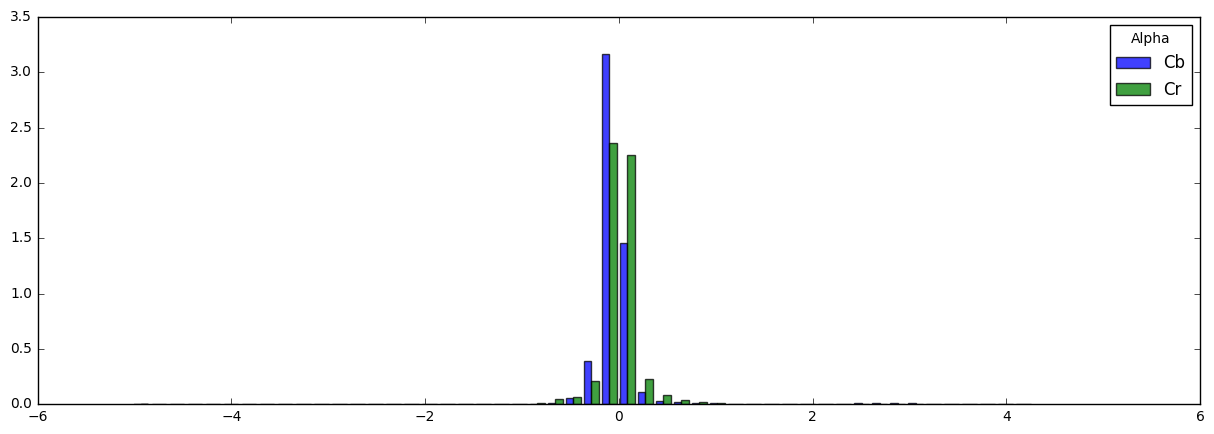

In [12]:
plt.figure(figsize=(15,5))
n, bins, patches = plt.hist([alphas_cb, alphas_cr], 50, normed=1, alpha=0.75, label=["Cb", "Cr"])
plt.legend(title="Alpha");

Based on this histogram, we can safely assume that $\bar{\alpha}$ is most likely between -1.5 and 1.5. Interestingly, this assumption generalizes to AV1. The following histogram shows the values of $\bar{\alpha}$ recorded during the execution of the AV1 encoder for QPs 20, 32, 43, 55, 63 for all the images contained in the subset-1. We removed outliers by discarding the values smaller than the first percentile and values greater than the last percentile.

In [131]:
def load_alphas(qp):
    alphas = []
    for file in os.listdir(str(qp)):
        if file.endswith(".csv"):
            alphas = np.concatenate( (alphas, genfromtxt(os.path.join(str(qp), file), delimiter=',')), axis=0)
    return alphas

def remove_outliers(alphas):
    q99, q1 = np.percentile(alphas, [99 ,1])
    return np.delete(alphas, np.where(np.logical_or(alphas < q1, alphas > q99)))

alphas_20 = remove_outliers(load_alphas(20))
alphas_32 = remove_outliers(load_alphas(32))
alphas_43 = remove_outliers(load_alphas(43))
alphas_55 = remove_outliers(load_alphas(55))
alphas_63 = remove_outliers(load_alphas(63))

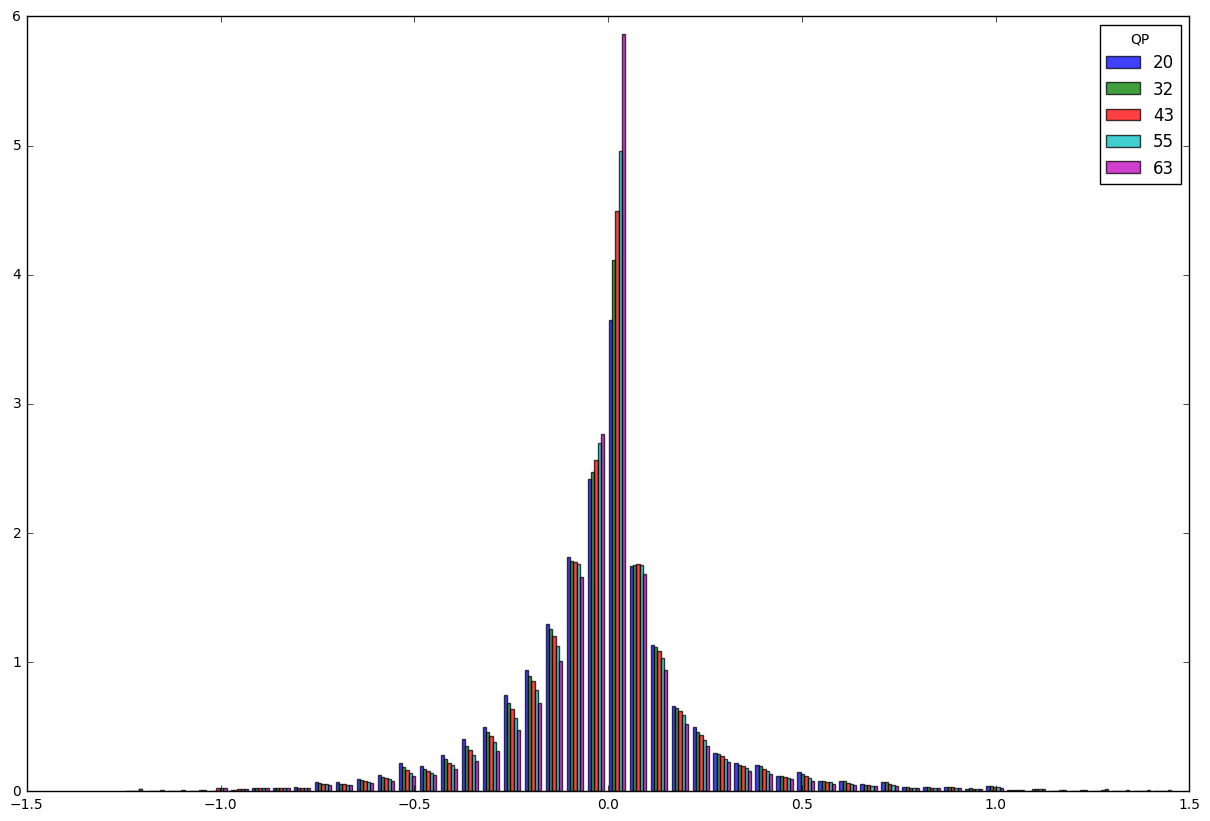

In [132]:
plt.figure(figsize=(15,10))
n, bins, patches = plt.hist([alphas_20, alphas_32, alphas_43, alphas_55, alphas_63], 50, normed=1, alpha=0.75, label=['20', '32', '43', '55', '63'])
plt.legend(title="QP");

Now that we know the range of $\bar{\alpha}$, let's consider the impact of quantization. As the histogram suggests, a fixed quantization step size is not desired. To obtain a non-uniform quantization table, we resort to Lloyds algorithm. In order to evaluate the impact of the alphabet size used for $\bar{\alpha}$, we compute all the quantization tables with alphabets of sizes 3 to 16. These alphabets are then used for CfL and the resulting PSNR is measured over the entire [Kodak Lossless True Color Image Suite](http://r0k.us/graphics/kodak/index.html). We make the assumption here that this generalizes to AV1.

In [ ]:
from oct2py import octave
octave.eval('pkg load communications')
octave.addpath('.')

def lloyds(alphas, k):
    octave.push('alphas', alphas)
    octave.push('k', k)
    octave.eval('[t, c] = lloyds(alphas, double(k));')
    return octave.pull('t'), octave.pull('c')

def cfl_prop_q(im, block_size, plane, codes):
    height, width, z = im.shape
    cfl = np.array(np.zeros((height, width)), dtype='uint8')
    alphas = []
    
    num_codes = len(codes)
    for c in range(0, num_codes-1):
        table[c] = (codes[c] + codes[c+1]) / 2
    
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            bY = im[y:y+block_size, x:x+block_size, 0]
            bC = im[y:y+block_size, x:x+block_size, plane]
            
            above_row = im[max(y-1,0), x:x+block_size, plane]
            left_col = im[y:y+block_size, max(x-1,0), plane]
            DC_PRED = np.mean([above_row, left_col])
            
            L = bY - np.mean(bY)
            C = bC - DC_PRED
            
            sLL = np.sum(L*L)
            sLC = np.sum(L*C)
            
            if sLL != 0:
                alpha = sLC / sLL
            else:
                alpha = 0
            alphas.append(alpha)
            
            i = 0
            while i < num_codes-1 and alpha > table[i]:
                i = i + 1
            alpha_q = codes[i]
            
            cfl[y:y+block_size, x:x+block_size] = np.round(alpha_q * L + DC_PRED)
            
    return cfl, alphas

In [125]:
k_psnrs = np.zeros((17,24));
psnr_cb = np.zeros((24,1));
f = 0
for file in sorted(os.listdir(img_folder)):
    if file.endswith(".png"):
        kodim = imread(os.path.join(img_folder, file), mode="YCbCr")
        for k in range(3,17):
            table, codes = lloyds(alphas_cb, k)
            cfl, alpha = cfl_prop_q(kodim, block_size, 1, codes)
            k_psnrs[k, f] = psnr(kodim[:,:,1], cfl)
            
        cfl_cb, alphas = cfl_prop(kodim, block_size, 1)
        psnr_cb[f] = psnr(kodim[:,:,1], cfl_cb)
        f = f + 1;

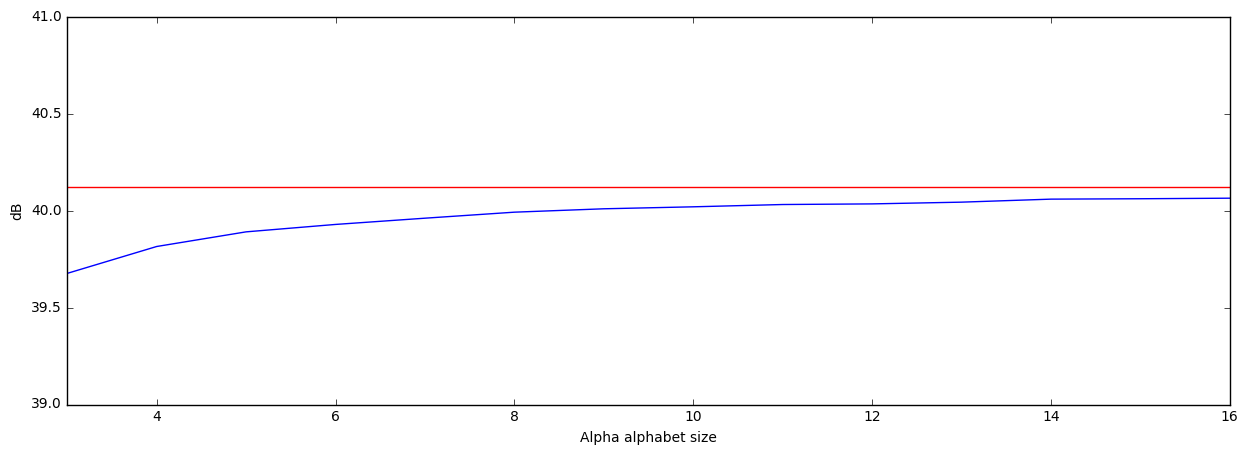

In [133]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,17), np.mean(k_psnrs, axis=1), np.arange(0,17), np.ones((17,1)) * np.mean(psnr_cb), 'r')
plt.gca().set_xlim([3, 16])
plt.gca().set_ylim([39, 41])
plt.xlabel('Alpha alphabet size')
plt.ylabel('dB');

It is important to notice that using only an alphabet of 3 $\alpha$s, the cost of quantization is less than 0.5 dB. Furthermore, diminishing returns are observed past an alphabet of 8 $\alpha$s. As we will explain in the next section, an alphabet of 8 $\alpha$s is particularly convenient, as once the sign bit is removed, both $\alpha$s can fit in one 4 bit symbol used by AV1's entropy coder.  

## References
[1] Steinar Midtskogen,"Improved chroma prediction" IETF draft-midtskogen-netvc-chromapred-02 https://tools.ietf.org/html/draft-midtskogen-netvc-chromapred-02 (October 2016)

[2] Nathan E. Egge and Jean-Marc Valin, "Predicting Chroma from Luma with Frequency Domain Intra Prediction", https://people.xiph.org/~unlord/spie_cfl.pdf (April 2016)